In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd /home/mabitbol/GBT-S140/analysis/

/home/mabitbol/GBT-S140/analysis


In [3]:
import foregrounds as fg
from scipy.optimize import curve_fit
import emcee
import corner

In [75]:
from __future__ import unicode_literals

figsize(16, 10)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 30
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 30
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 24
rcParams['legend.borderaxespad'] = 1

rcParams['axes.labelsize'] = 30
rcParams['axes.titlesize'] = 30

In [5]:
x = np.load('spectrum_data_full.npy')

In [6]:
bigfreqs, bigdata, bigerrs = x

In [8]:
# GBT
gbtA = 18.0860055748
gbtB = 17.5061433323
gbtC = 17.7466661872
gbtAerr = 2.
gbtBerr = 2.
gbtCerr = 2.
gbtfreqs = [4.575e9, 5.625e9, 6.125e9]
gbtflux = [gbtA, gbtB, gbtC]
gbterrs = [gbtAerr, gbtBerr, gbtCerr]

In [9]:
beam = pi*((45./60.)*pi/180.)**2
beam2 = pi*((1./60./60.)*pi/180.)**2

In [10]:
def signal(freqs, EM, Asd, nup, Ad, Bd, Td, Acmb):
    fffit = fg.freefreep(freqs, EM=EM, Te=8000)
    amefit = fg.ame(freqs, Asd=Asd, nup=nup) 
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=Td)
    ccmb = fg.cmb(freqs, A=Acmb)
    return (fffit + dustfit + amefit + ccmb) * beam

In [11]:
def signal2(freqs, EM1, EM2, abeam, Ad, Bd, Td, Acmb):
    fffit = fg.freefreep(freqs, EM=EM1, Te=8000) * beam
    fffit2 = fg.freefreep(freqs, EM=EM2, Te=8000) * abeam
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=Td) * beam
    ccmb = fg.cmb(freqs, A=Acmb) * beam
    return fffit + fffit2 + dustfit + ccmb

In [12]:
def lnlike(theta, x, y, yerr):
    EM, Asd, nup, Ad, Bd, Td, Acmb = theta
    fffit = fg.freefreep(x, EM=EM, Te=8000.)
    dustfit = fg.thermal_dust(x, Ad=Ad, Bd=Bd, Td=Td)
    amefit = fg.ame(x, Asd=Asd, nup=nup) 
    ccmb = fg.cmb(x, A=Acmb)
    model = (fffit + dustfit + amefit + ccmb) * beam
    return -0.5 * (np.sum((y - model)**2. * yerr**-2.))

In [13]:
def lnlike2(theta, x, y, yerr):
    EM1, EM2, abeam, Ad, Bd, Td, Acmb = theta
    fffit = fg.freefreep(x, EM=EM1, Te=8000.) * beam
    fffit2 = fg.freefreep(x, EM=EM2, Te=8000.) * abeam
    dustfit = fg.thermal_dust(x, Ad=Ad, Bd=Bd, Td=Td) * beam
    ccmb = fg.cmb(x, A=Acmb) * beam
    model = fffit + fffit2 + dustfit + ccmb
    return -0.5 * np.sum((y-model)**2 / (yerr**2))

In [14]:
thetaff = [300, 5.27e8, pi * (2.49/(180. / pi * 60. * 60.))**2, 1157e-6, 1.8339, 19.98, -20.86e-6]
thetasd = [339, 1383e-6, 30.89e9, 1114e-6, 1.9432, 19.42, 142.37e-6]

In [16]:
mask1 = (bigfreqs <= 3e12) & (bigfreqs != 100e9) & (bigfreqs != 217e9)

In [103]:
2*7 -2*lnlike(thetasd, bigfreqs[mask1], bigdata[mask1], bigerrs[mask1])

54.417525341648393

In [104]:
2*7-2*lnlike2(thetaff, bigfreqs[mask1], bigdata[mask1], bigerrs[mask1])

70.063828969774846

In [108]:
np.exp((54.4 - 70.0)/2) * 100

0.04097349789797864

In [19]:
freqs = np.logspace(8, 13, 2000)
nu = freqs*1.e-9

In [21]:
mask2 = (bigfreqs <= 3e12) & (bigfreqs != 100e9) & (bigfreqs != 217e9) \
        & (bigfreqs!=4.575e9) & (bigfreqs!=5.625e9) & (bigfreqs!=6.125e9)

In [23]:
mask3 = ~((bigfreqs != 100e9) & (bigfreqs != 217e9))

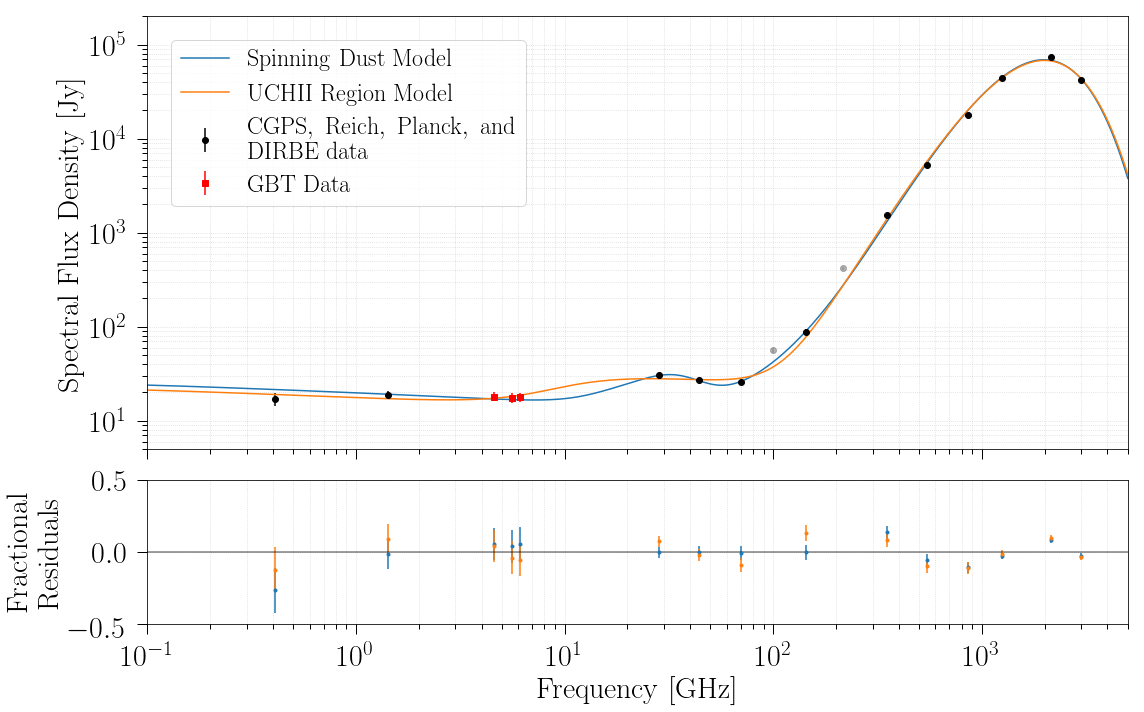

In [67]:
f, ax = plt.subplots(2, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (16,10))

ax[0].plot(nu, signal(freqs, *thetasd), label='$\mathrm{Spinning\ Dust\ Model}$')
ax[0].plot(nu, signal2(freqs, *thetaff), label='$\mathrm{UCHII\ Region\ Model}$')

ax[0].errorbar(bigfreqs[mask2]*1e-9, bigdata[mask2], yerr=bigerrs[mask2], fmt='ko', 
         label='$\mathrm{CGPS,\ Reich,\ Planck,\ and}$\n$\mathrm{DIRBE\ data}$')
ax[0].errorbar(np.array(gbtfreqs)*1e-9, gbtflux, yerr=gbterrs, fmt='.', marker='s', color='r', markersize=6, 
         label='$\mathrm{GBT\ Data}$')
ax[0].errorbar(bigfreqs[mask3]*1e-9, bigdata[mask3], yerr=bigerrs[mask3], fmt='o', color='grey', alpha=0.6)

ax[1].errorbar(bigfreqs[mask1]*1e-9, (bigdata[mask1]-signal(bigfreqs[mask1], *thetasd))/bigdata[mask1], 
               yerr=bigerrs[mask1]/bigdata[mask1], color='C0', fmt='.')
ax[1].errorbar(bigfreqs[mask1]*1e-9, (bigdata[mask1]-signal2(bigfreqs[mask1], *thetaff))/bigdata[mask1],
               yerr=bigerrs[mask1]/bigdata[mask1], color='C1', fmt='.')
ax[1].axhline(0, color='k', alpha=0.5)


ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xlabel('$\mathrm{Frequency\ [GHz]}$')
ax[0].set_ylabel('$\mathrm{Spectral\ Flux\ Density\ [Jy]}$')
ax[1].set_ylabel('$\mathrm{Fractional}$\n $\mathrm{Residuals}$')
ax[0].legend(loc=2, ncol=1)
ax[0].grid(ls='dotted', alpha=0.5)
ax[0].grid(which='minor', ls='dotted', alpha=0.5)
ax[1].grid(ls='dotted', alpha=0.5)
ax[1].grid(which='minor', ls='dotted', alpha=0.5)
ax[0].set_ylim(5, 2e5)
ax[0].set_xlim(1e-1, 5e3)
ax[1].set_ylim(-0.5, 0.5)
tight_layout()
#savefig('../notebooks/fullspectrum_with_residuals.pdf', format='pdf')

In [54]:
np.sum(mask1)

15

In [55]:
# red chi sq SD
print np.sum( (bigdata[mask1] - signal(bigfreqs[mask1], *thetasd))**2 / bigerrs[mask1]**2  ) / (15-7.)

5.05219066771


In [56]:
# red chi sq SD
print np.sum( (bigdata[mask1] - signal2(bigfreqs[mask1], *thetaff))**2 / bigerrs[mask1]**2  ) / (15-7.)

7.00797862122


In [59]:
diffuseff = fg.freefreep(freqs, EM=thetasd[0], Te=8000) * beam
spinninddustfit = fg.ame(freqs, Asd=thetasd[1], nup=thetasd[2]) * beam
thermaldustfit = fg.thermal_dust(freqs, Ad=thetasd[3], Bd=thetasd[4], Td=thetasd[5]) * beam
cmbfit = fg.cmb(freqs, A=thetasd[6]) * beam

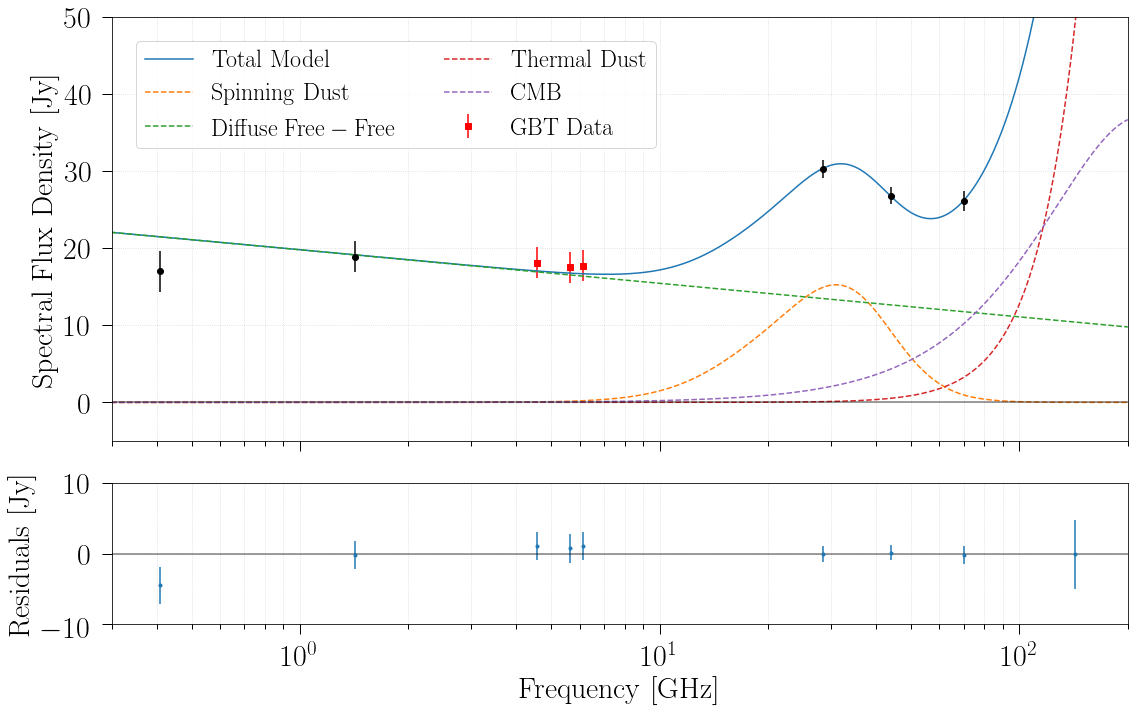

In [100]:
f, ax = plt.subplots(2, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (16,10))

ax[0].errorbar(bigfreqs[mask2]*1e-9, bigdata[mask2], yerr=bigerrs[mask2], fmt='ko')
ax[0].errorbar(np.array(gbtfreqs)*1e-9, gbtflux, yerr=gbterrs, fmt='.', marker='s', color='r', markersize=6, 
         label='$\mathrm{GBT\ Data}$')

ax[0].plot(nu, signal(freqs, *thetasd), label='$\mathrm{Total\ Model}$')

ax[0].plot(nu, spinninddustfit, ls='dashed', label='$\mathrm{Spinning\ Dust}$')
ax[0].plot(nu, diffuseff, ls='dashed', label='$\mathrm{Diffuse\ Free-Free}$')
ax[0].plot(nu, thermaldustfit, ls='dashed', label='$\mathrm{Thermal\ Dust}$')
ax[0].plot(nu, cmbfit, ls='dashed', label='$\mathrm{CMB}$')
ax[0].axhline(0, color='k', alpha=0.5)

ax[1].errorbar(bigfreqs[mask1]*1e-9, bigdata[mask1]-signal(bigfreqs[mask1], *thetasd), 
               yerr=bigerrs[mask1], fmt='.')
ax[1].axhline(0, color='k', alpha=0.5)


ax[0].set_xscale('log')
ax[0].set_ylim(-5, 50)
ax[0].set_xlim(0.3, 200)
ax[1].set_xlabel('$\mathrm{Frequency\ [GHz]}$')
ax[0].set_ylabel('$\mathrm{Spectral\ Flux\ Density\ [Jy]}$')
ax[1].set_ylabel('$\mathrm{Residuals\ [Jy]}$')
ax[0].legend(loc=2, ncol=2)
ax[0].grid(ls='dotted', alpha=0.5)
ax[0].grid(which='minor', ls='dotted', alpha=0.5)
ax[1].grid(ls='dotted', alpha=0.5)
ax[1].grid(which='minor', ls='dotted', alpha=0.5)
ax[1].set_ylim(-10, 10)
tight_layout()
savefig('../notebooks/spinningdust_fit_residuals.pdf', format='pdf')

In [92]:
diffuseff1 = fg.freefreep(freqs, EM=thetaff[0], Te=8000) * beam
uchiiff = fg.freefreep(freqs, EM=thetaff[1], Te=8000) * thetaff[2]
thermaldustfit1 = fg.thermal_dust(freqs, Ad=thetaff[3], Bd=thetaff[4], Td=thetaff[5]) * beam
cmbfit1 = fg.cmb(freqs, A=thetaff[6]) * beam

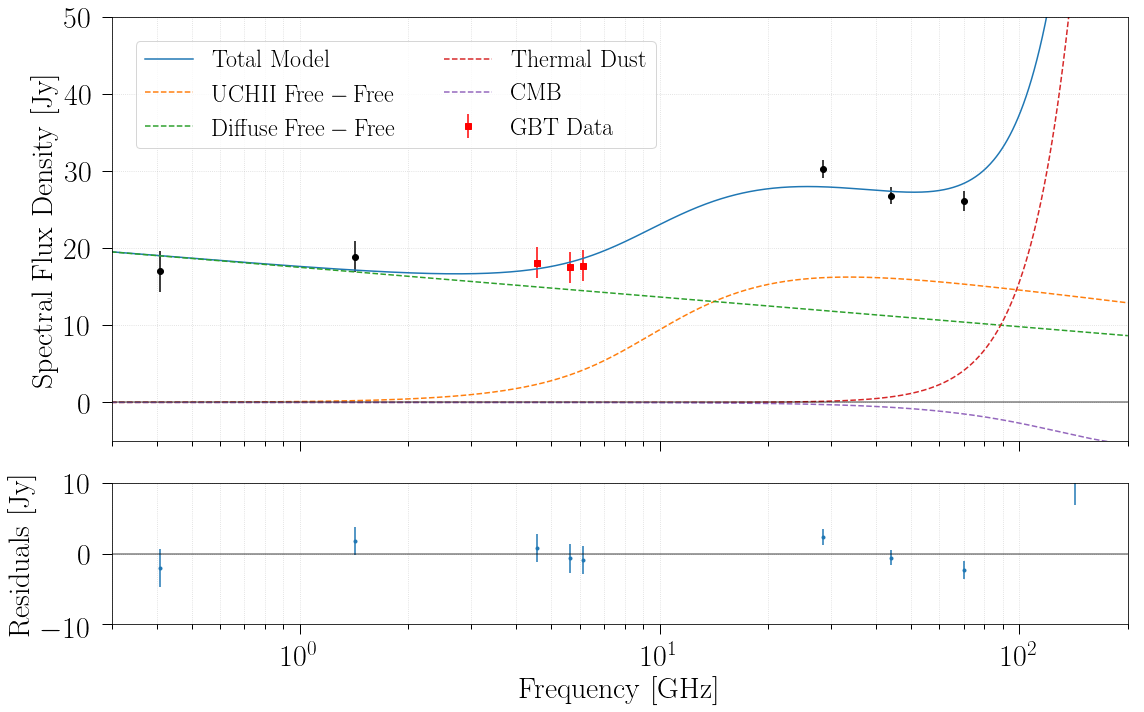

In [99]:
f, ax = plt.subplots(2, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (16,10))

ax[0].errorbar(bigfreqs[mask2]*1e-9, bigdata[mask2], yerr=bigerrs[mask2], fmt='ko')
ax[0].errorbar(np.array(gbtfreqs)*1e-9, gbtflux, yerr=gbterrs, fmt='.', marker='s', color='r', markersize=6, 
         label='$\mathrm{GBT\ Data}$')

ax[0].plot(nu, signal2(freqs, *thetaff), label='$\mathrm{Total\ Model}$')

ax[0].plot(nu, uchiiff, ls='dashed', label='$\mathrm{UCHII\ Free-Free}$')
ax[0].plot(nu, diffuseff1, ls='dashed', label='$\mathrm{Diffuse\ Free-Free}$')
ax[0].plot(nu, thermaldustfit1, ls='dashed', label='$\mathrm{Thermal\ Dust}$')
ax[0].plot(nu, cmbfit1, ls='dashed', label='$\mathrm{CMB}$')
ax[0].axhline(0, color='k', alpha=0.5)

ax[1].errorbar(bigfreqs[mask1]*1e-9, bigdata[mask1]-signal2(bigfreqs[mask1], *thetaff),
               yerr=bigerrs[mask1], fmt='.')
ax[1].axhline(0, color='k', alpha=0.5)


ax[0].set_xscale('log')
ax[0].set_ylim(-5, 50)
ax[0].set_xlim(0.3, 200)
ax[1].set_xlabel('$\mathrm{Frequency\ [GHz]}$')
ax[0].set_ylabel('$\mathrm{Spectral\ Flux\ Density\ [Jy]}$')
ax[1].set_ylabel('$\mathrm{Residuals\ [Jy]}$')
ax[0].legend(loc=2, ncol=2)
ax[0].grid(ls='dotted', alpha=0.5)
ax[0].grid(which='minor', ls='dotted', alpha=0.5)
ax[1].grid(ls='dotted', alpha=0.5)
ax[1].grid(which='minor', ls='dotted', alpha=0.5)
ax[1].set_ylim(-10, 10)
tight_layout()
savefig('../notebooks/uchii_fit_residuals.pdf', format='pdf')